# Statistical Methods Project

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats.mstats import winsorize
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats

# EDA (data description, data preprocessing)

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/ov3ipo/SM_Project/main/life_expectancy.csv")
# remove trailing space in columns name and format display function
pd.options.display.float_format = '{:.4f}'.format
df = df.rename(columns=lambda x: x.strip())

# overview on data statistic
display(df.head(10))
display(df.info())

# get quantitative and qualitative data
numeric_cols = df.drop(columns=["Status", "Country"], axis=1).columns

10 rows × 22 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

None

## Data description

### Univariate

#### Qualitative

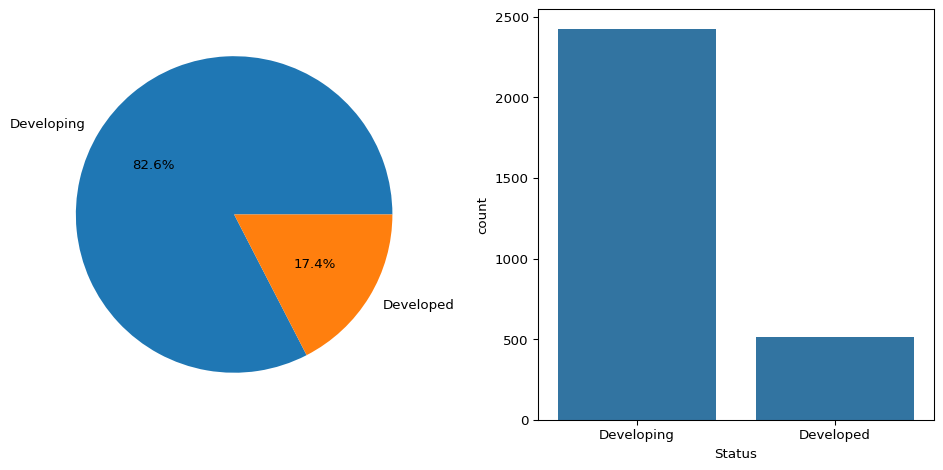

In [3]:
plt.figure(figsize = (10,5))
plt.subplot(1, 2, 1)
x = df['Status'].value_counts().reset_index()
plt.pie(x=x['count'], labels=x['Status'], autopct="%0.1f%%")
plt.subplot(1, 2, 2)
sns.countplot(df, x="Status")
plt.tight_layout()
plt.show()

``` {markdown}
Remark:
- Why didn't we consider the Country col in this case?
- State what you see in the chart
```

#### Quantitative

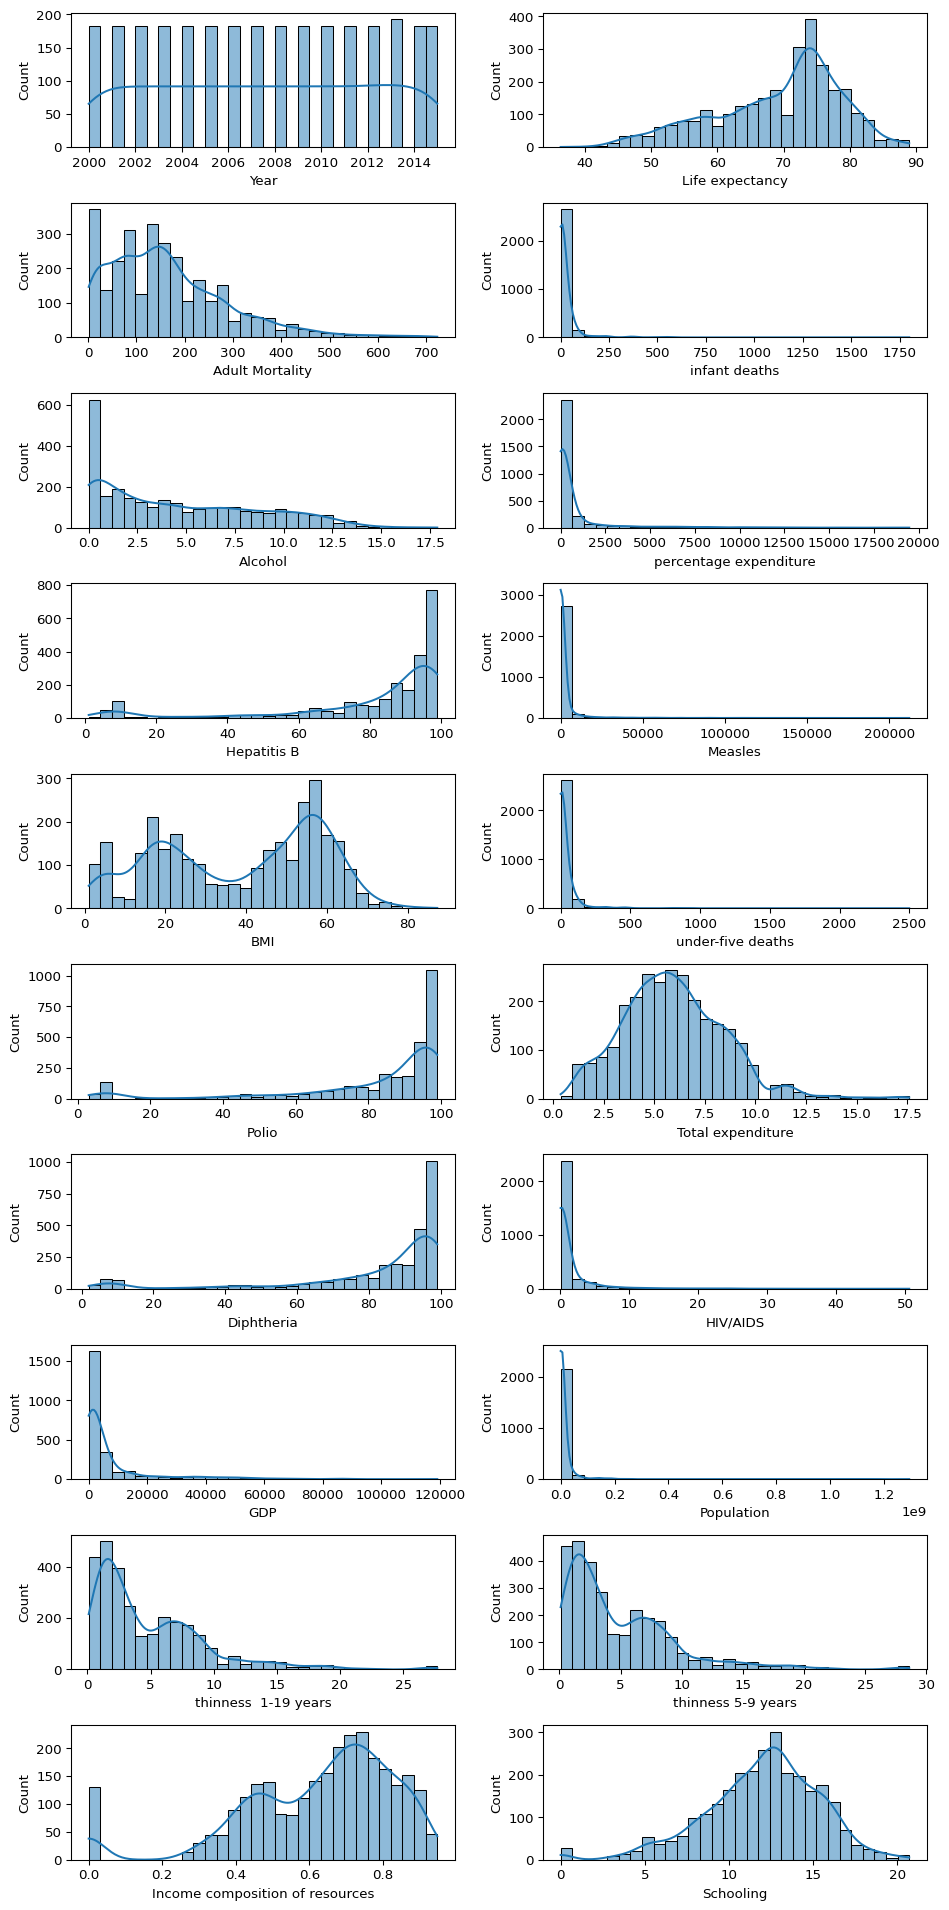

In [4]:
plt.figure(figsize=(10, 20))
for i, col in enumerate(numeric_cols):
    plt.subplot(10, 2, i + 1)
    sns.histplot(df, x=col, bins=30, kde=True)
plt.tight_layout()
plt.show()

``` {markdown}
Remark:
- State what you see in the chart
```

### Bivariate

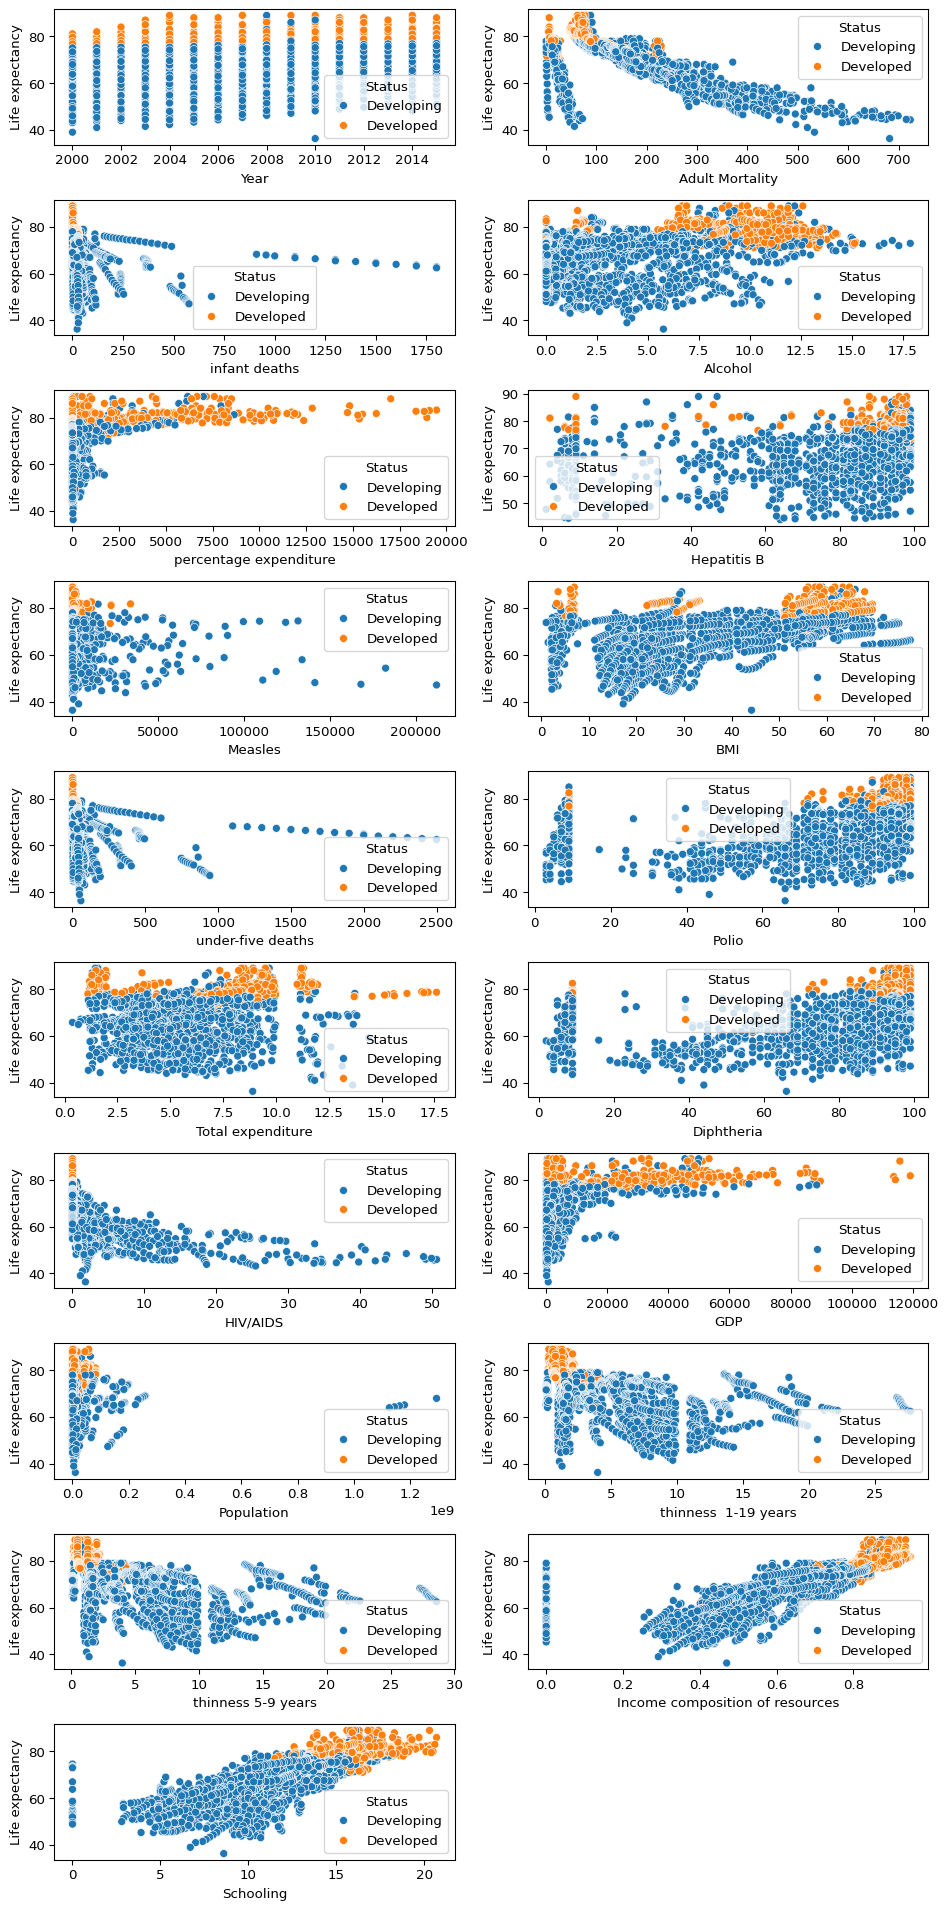

In [5]:
plt.figure(figsize=(10, 20))
index = np.argwhere(numeric_cols=="Life expectancy")
for i, col in enumerate(np.delete(numeric_cols, index)):
    plt.subplot(10, 2, i + 1)
    sns.scatterplot(df, x=col, y="Life expectancy", hue="Status", legend="auto")
plt.tight_layout()
plt.show()

``` {markdown}
Remark:
- State what you see in the chart
- Base on the scatter plot can you spot any variables that seem to have a linear relationship with the target variabel?
```

### Overall statistic

In [6]:
display(df.describe().T)

## Data preprocessing (NAs, outliers, duplicateds, label encoding)

### Missing

In [7]:
print("\nPreprocessing\n")
print(df.isna().sum())
df = df.interpolate(method='linear', limit_direction='forward')
print("\nPostprocessing\n")
print(df.isna().sum())


Preprocessing

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
thinness  1-19 years                34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64

Postprocessing

Country                            0
Year                               0
Status                

/tmp/ipykernel_86180/365239556.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear', limit_direction='forward')

### Duplicated

In [8]:
print(f"Total duplicated values: {df.duplicated().sum()}")

Total duplicated values: 0

### Outliers

#### Detect outliers

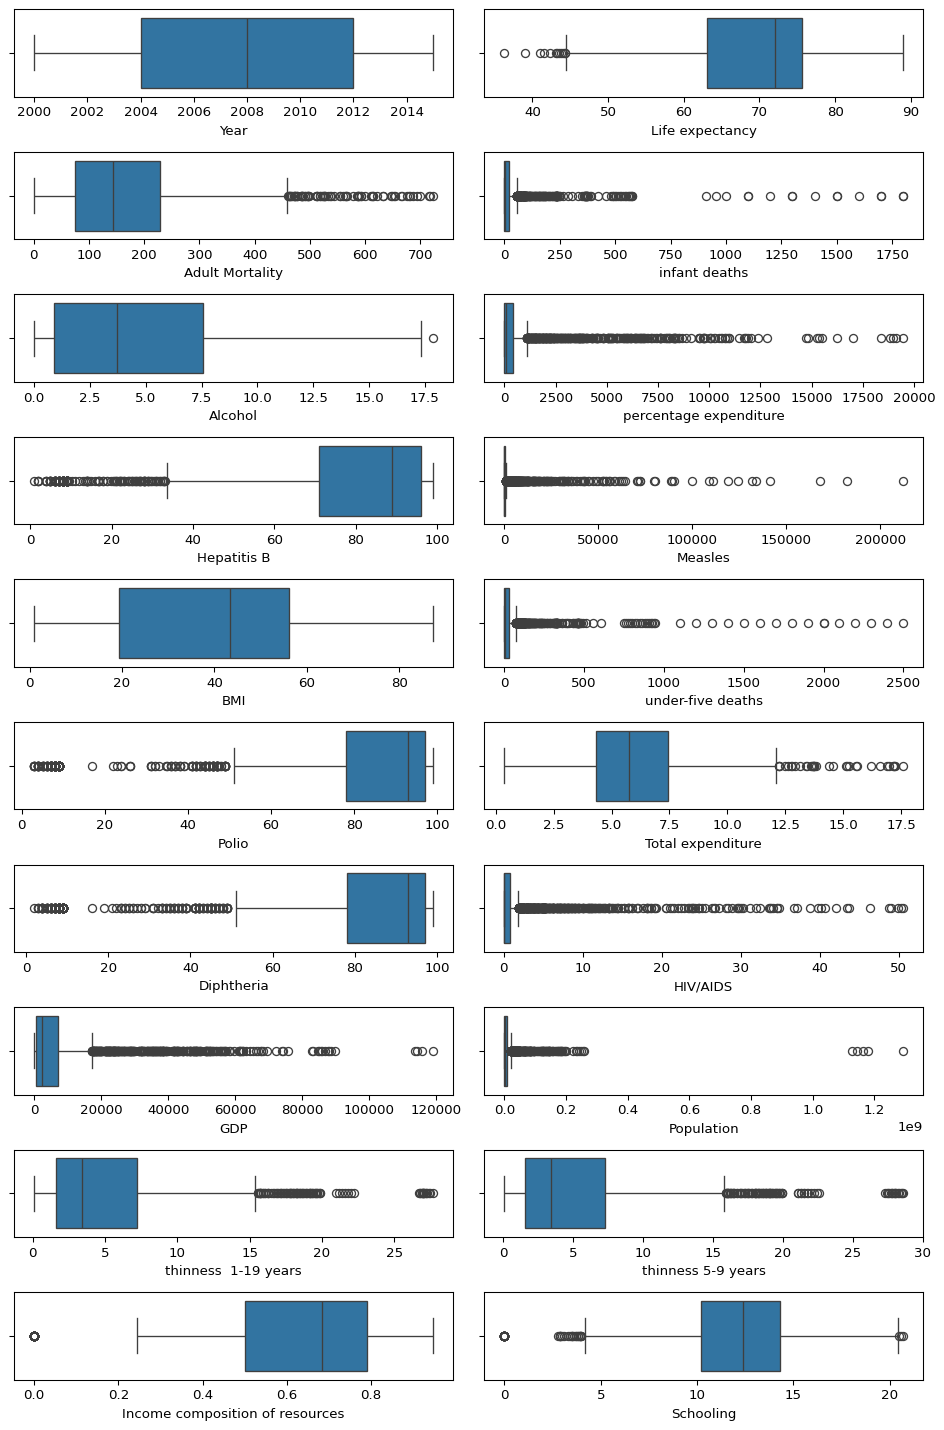

In [9]:
plt.figure(figsize=(10, 15))
for i, col in enumerate(numeric_cols):
    plt.subplot(10, 2, i + 1)
    sns.boxplot(df, x=col)
plt.tight_layout()
plt.show()

# detect outliers
def detectOutliers(data):
    outliers_arr = []
    for col in data.columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col].count()
        outliers_arr.append(outliers)
    return pd.DataFrame(outliers_arr, index=data.columns, columns=["Total outliers"])

numeric_data = df.drop(columns=["Status", "Country"], axis=1)
outliers = detectOutliers(numeric_data)
display(outliers)

``` {markdonw}
Why we should not use variable with high outliers -> because regression can heavily be affected by these outliers, hence we should only choose those with low outliers
Potential variable for regression of target
- Year
- Adult Mortality
- Alcohol
- BMI
- Total expenditure
- thinness 1-19 years
- thinness 5-9 years
- Income composition of resources
- Schooling

One reason is that there was a large differences between developed, devloping and underdeveloped country.
This can be the primary factor explained why outliers existed. Hence they are not abnormal observations.
->Assumption 1: OUTLIERS SHOULD NOT BE REMOVED
```

#### Dealing with outliers

In [10]:
potential_var = outliers[(outliers["Total outliers"] < 150)].index
outliers_var = outliers[(outliers["Total outliers"] > 0) & (outliers["Total outliers"] < 150)].index
df_outliers = df.copy()

##### With ouliers

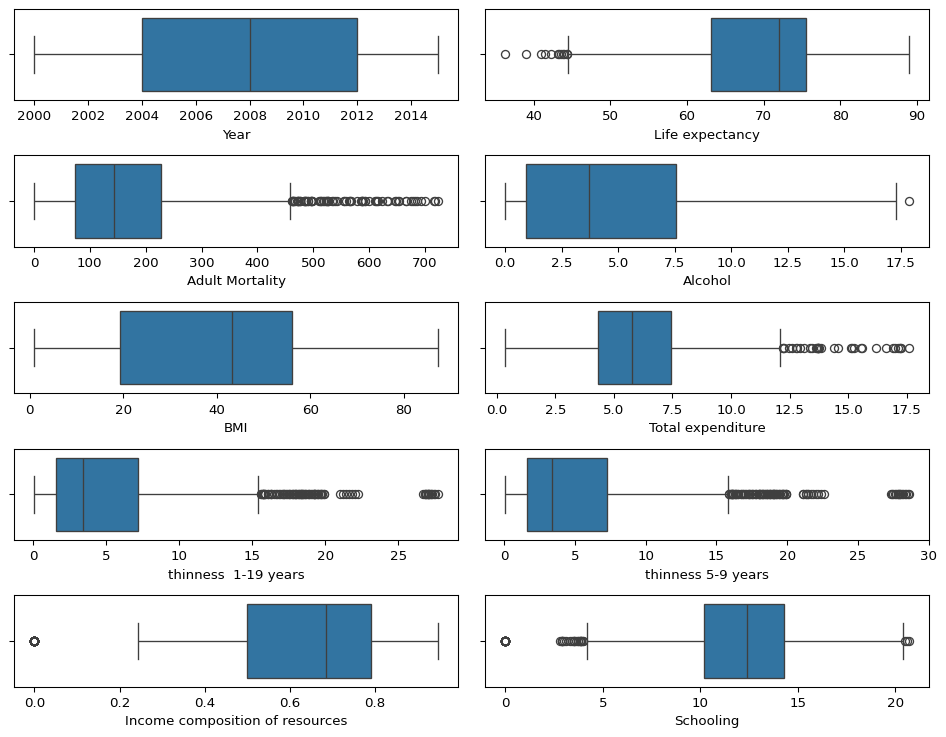

In [11]:
display(detectOutliers(df_outliers[potential_var]))
plt.figure(figsize=(10, 15))
for i, col in enumerate(potential_var):
    plt.subplot(10, 2, i + 1)
    sns.boxplot(df_outliers, x=col)
plt.tight_layout()
plt.show()

##### Without ouliers

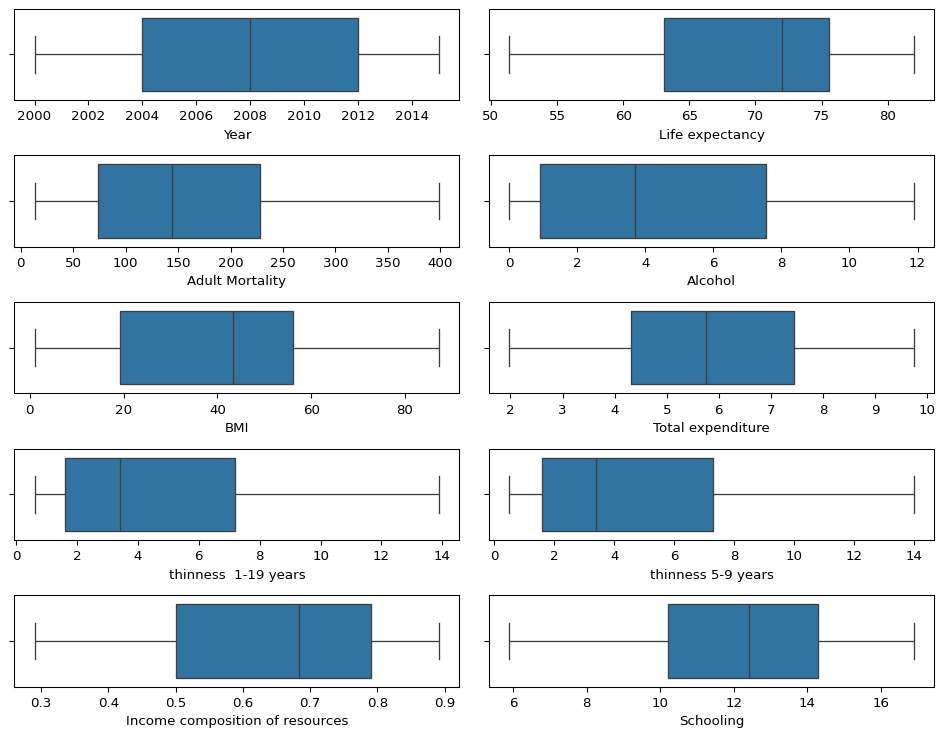

In [12]:
for col in outliers_var:
    if col != "BMI":
        df_outliers[col] = winsorize(df_outliers[col], limits=[0.05, 0.05])

display(detectOutliers(df_outliers[potential_var]))
plt.figure(figsize=(10, 15))
for i, col in enumerate(potential_var):
    plt.subplot(10, 2, i + 1)
    sns.boxplot(df_outliers, x=col)
plt.tight_layout()
plt.show()

### Comprare statistic between with and without outliers

In [13]:
# assign new dataframe to use for regression
df_reg_n = df[potential_var]
df_reg_y = df_outliers[potential_var]
display(df_reg_n.describe().T)
display(df_reg_y.describe().T)

# Linear Regression Analysis

## Correlation Matrix

### With outliers

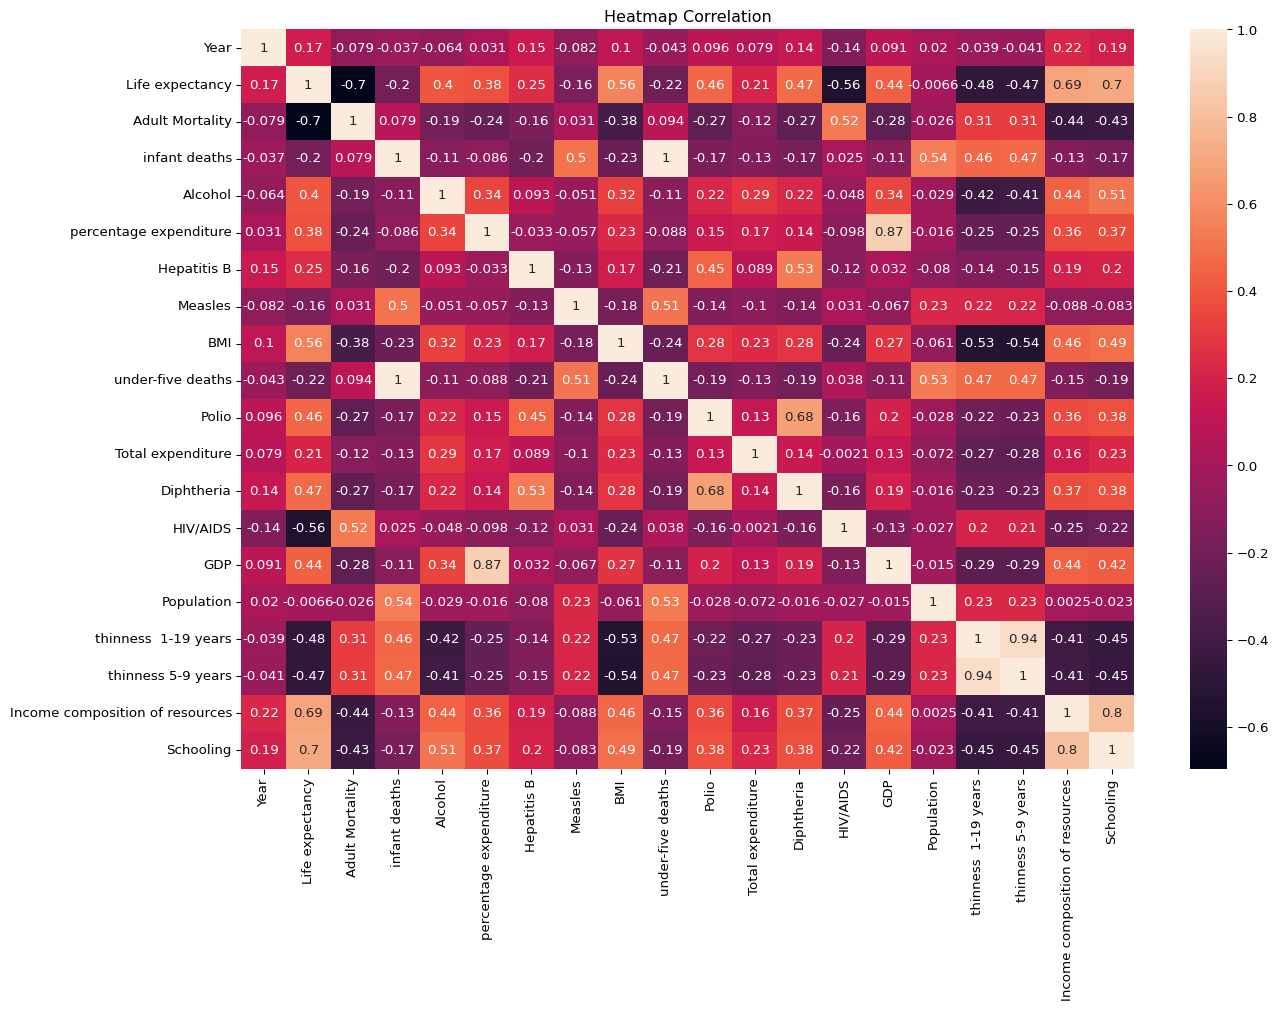

Variables have correlation larger than 0.5: 
Adult Mortality                   -0.6957
BMI                                0.5564
HIV/AIDS                          -0.5559
Income composition of resources    0.6909
Schooling                          0.7043
Name: Life expectancy, dtype: float64

In [14]:
numeric_df = df.drop(columns=["Country", "Status"])
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_df.corr(), annot=True)
plt.title('Heatmap Correlation')
plt.show()

# get variables that has high correlation with Life expectancy
corrs = numeric_df.corr()['Life expectancy'].drop('Life expectancy')
high_corr = corrs[corrs.abs() > 0.5]
print("Variables have correlation larger than 0.5: ")
print(high_corr)

### Without outliers

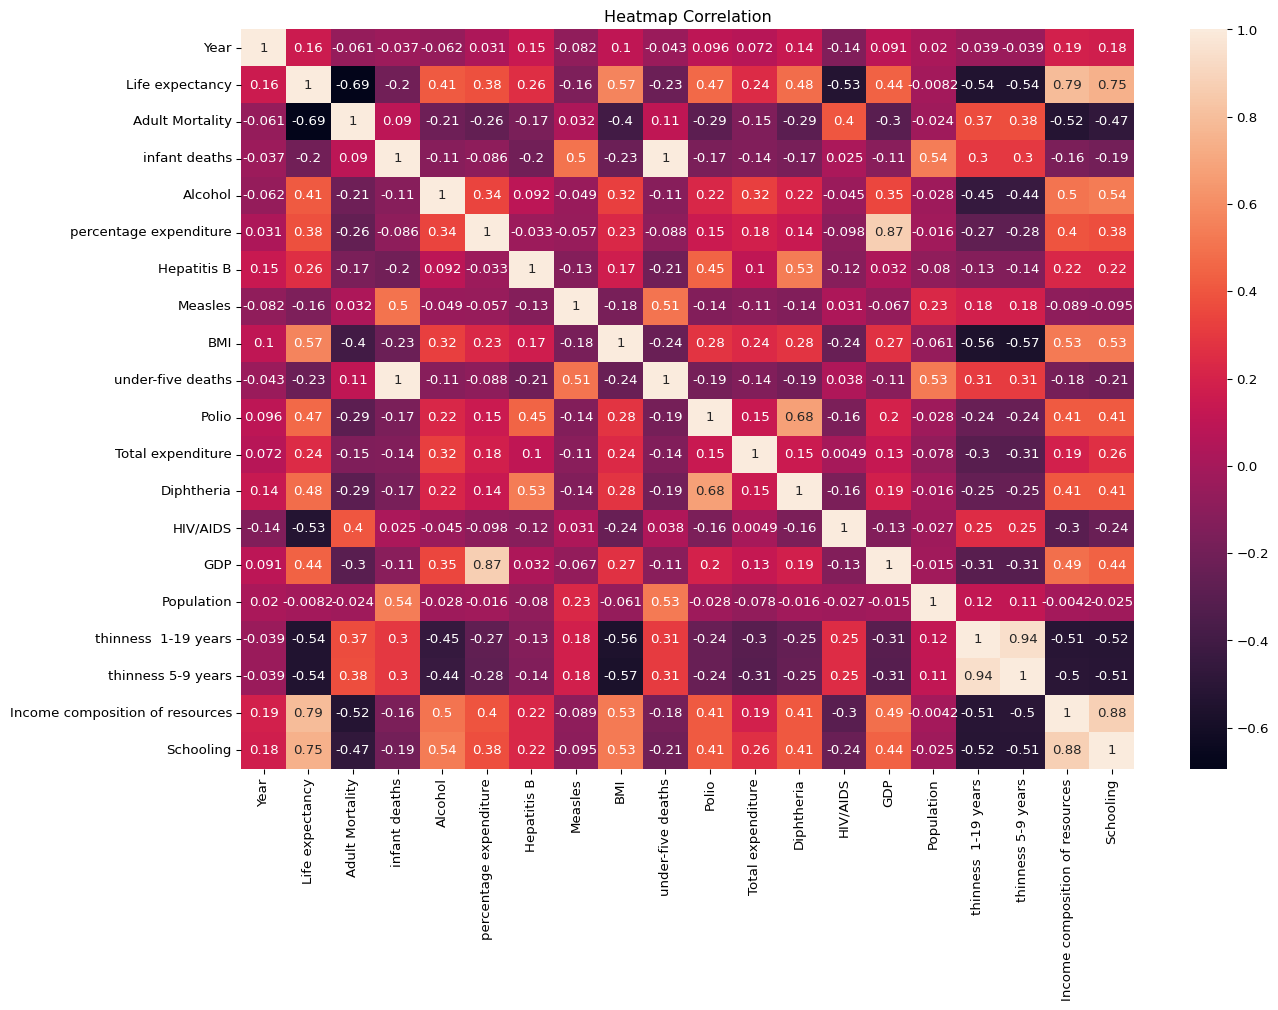

Variables have correlation larger than 0.5: 
Adult Mortality                   -0.6938
BMI                                0.5672
HIV/AIDS                          -0.5286
thinness  1-19 years              -0.5444
thinness 5-9 years                -0.5445
Income composition of resources    0.7913
Schooling                          0.7469
Name: Life expectancy, dtype: float64

In [15]:
numeric_df_outliers = df_outliers.drop(columns=["Country", "Status"])
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_df_outliers.corr(), annot=True)
plt.title('Heatmap Correlation')
plt.show()

# get variables that has high correlation with Life expectancy
corrs = numeric_df_outliers.corr()['Life expectancy'].drop('Life expectancy')
high_corr = corrs[corrs.abs() > 0.5]
print("Variables have correlation larger than 0.5: ")
print(high_corr)

``` {remark}
Corralations between with and without outliers does not change too much, which indicates
that the outliers does not generally affect our data
-> Confirm assumption: OUTLIERS ARE NOT REMOVED
```

In [16]:
# update data use for regress
df_regress = df_reg_y[["Life expectancy", "BMI", "Adult Mortality"]]

## Least square regression

In [17]:
X1 = df_regress['Adult Mortality']
X2 = df_regress['BMI']
y = df_regress['Life expectancy']

model1 = smf.ols(formula='y ~ X1', data=df_regress).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     2725.
Date:                Wed, 12 Jun 2024   Prob (F-statistic):               0.00
Time:                        18:07:56   Log-Likelihood:                -9624.9
No. Observations:                2938   AIC:                         1.925e+04
Df Residuals:                    2936   BIC:                         1.927e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     78.2677      0.209    375.000      0.0

In [18]:
model2 = smf.ols(formula='y ~ X2', data=df_regress).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     1392.
Date:                Wed, 12 Jun 2024   Prob (F-statistic):          9.06e-250
Time:                        18:07:56   Log-Likelihood:                -10019.
No. Observations:                2938   AIC:                         2.004e+04
Df Residuals:                    2936   BIC:                         2.005e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.6230      0.292    204.068      0.0

In [19]:
model3 = smf.ols(formula='y ~ X1 + X2', data=df_regress).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     2042.
Date:                Wed, 12 Jun 2024   Prob (F-statistic):               0.00
Time:                        18:07:56   Log-Likelihood:                -9308.6
No. Observations:                2938   AIC:                         1.862e+04
Df Residuals:                    2935   BIC:                         1.864e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.5964      0.344    204.999      0.0

## Check residuals for 4 assumptions

### Assumption 1: Linearity

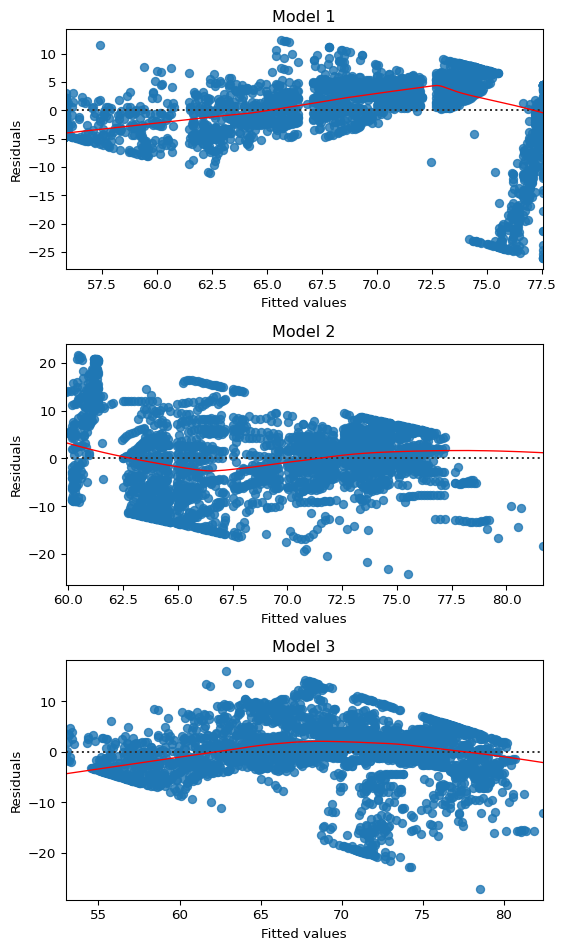

In [20]:
models = [model1, model2, model3]
plt.figure(figsize=(6, 10))
for i, model in enumerate(models):
    plt.subplot(3, 1, i+1)
    sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, line_kws={'color': 'red', 'lw': 1})
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title(f'Model {i+1}')
plt.tight_layout()
plt.show()

### Assumption 2: Independent

### Assumption 3: Homoscedasticity

### Assumption 4: Normality of Residuals

## Normality check

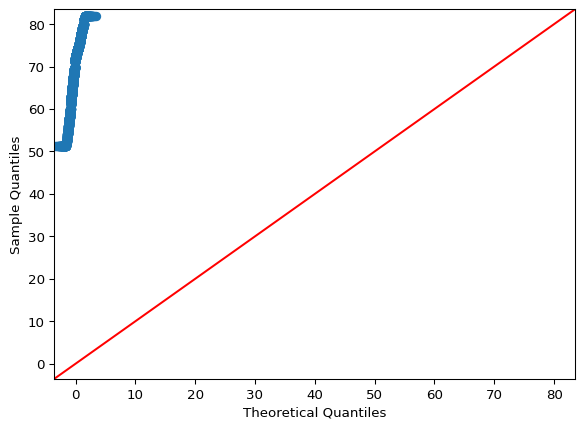

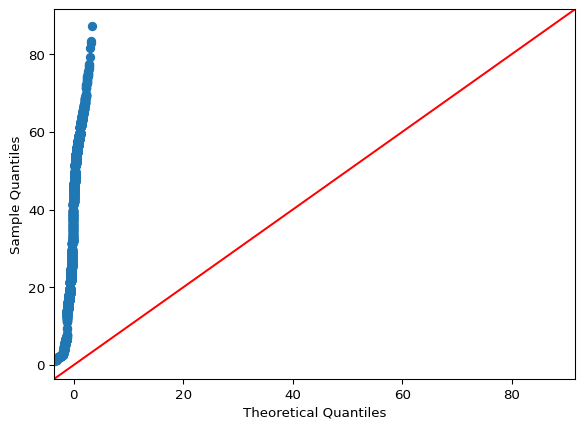

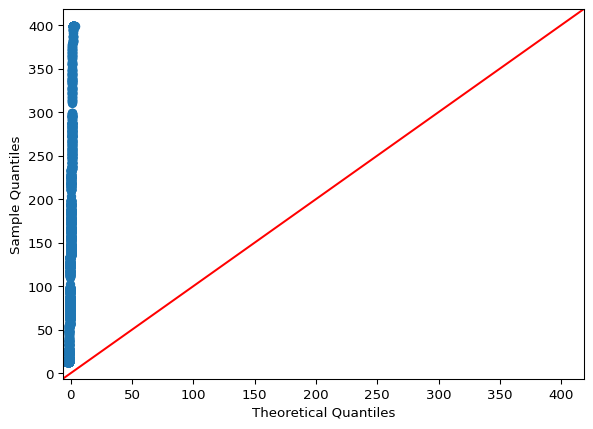

In [21]:
# add semicolon to prevent duplicated graph issue
sm.qqplot(df_regress["Life expectancy"], line='45');
sm.qqplot(df_regress['BMI'], line='45');
sm.qqplot(df_regress['Adult Mortality'], line='45');

In [22]:
# use Shapiro-Wilk test to test again
for col in df_regress.columns:
    test = shapiro(df_regress[col])
    print(f'Test statistic = {test[0]}, p-value = {test[1]}')
    if test[1] > 0.05: print(f'{col} looks normal distributed (fail to reject H0)\n')
    else: print(f'{col} does not normal distributed (reject H0)\n')

Test statistic = 0.9310970846633301, p-value = 7.980497111418431e-35
Life expectancy does not normal distributed (reject H0)

Test statistic = 0.9312720150595797, p-value = 8.652378014696785e-35
BMI does not normal distributed (reject H0)

Test statistic = 0.9365956696730842, p-value = 1.0988645476334773e-33
Adult Mortality does not normal distributed (reject H0)


``` {markdown}
Remark:
Both the QQ plot and the Shapiro-Wilk test indicate that our dataset is not normally
distributed. However, as our dataset is a sample from the years 2000 to 2015 and 
continues to be updated annually, the increase in size may lead it to approximate
normality over time, following the Central Limit Theorem (CLT). The CLT suggests that 
with a large enough sample size, the sampling distribution of the mean will approximate 
a normal distribution, regardless of the initial distribution of the data. This 
principle is particularly important in inferential statistics, where the assumption of
normality supports the validity of various statistical tests and the calculation of
confidence intervals.
```

## Construct confidence interval

### Propotion

In [23]:
def CI_propotion(sample_counts, sample_n, alpha):
    p_hat = sample_counts/sample_n
    z = stats.norm.ppf(1 - alpha / 2)
    stdE = np.sqrt(p_hat * (1-p_hat) / sample_n)
    marginE = z * stdE
    lower = p_hat - marginE
    upper = p_hat + marginE
    return lower, upper

n = len(df_regress)
alpha = 0.05

x1 = sum(df_regress[(df_regress["Life expectancy"]>60)][["Life expectancy"]].value_counts())
lower_b, upper_b = CI_propotion(x1, n, 0.05)
print(f"95% confidence interval propotion of Life expectancy < 50 is between [{lower_b}, {upper_b}]")

x2 = sum(df_regress[(df_regress["BMI"] < 20)][["BMI"]].value_counts())
lower_b, upper_b = CI_propotion(x2, n, 0.05)
print(f"95% confidence interval propotion of entries with BMI < 20 is between [{lower_b}, {upper_b}]")

x3 = sum(df_regress[(df_regress["Adult Mortality"] < 20)][["Adult Mortality"]].value_counts())
lower_b, upper_b = CI_propotion(x3, n, 0.05)
print(f"95% confidence interval propotion with Adult Morality < 100 is between [{lower_b}, {upper_b}]")

95% confidence interval propotion of Life expectancy < 50 is between [0.7832991124399449, 0.8123441823183941]
95% confidence interval propotion of entries with BMI < 20 is between [0.24851754687011873, 0.28041369887528633]
95% confidence interval propotion with Adult Morality < 100 is between [0.09343170906044714, 0.11555399550047867]

### Mean

In [24]:
def CI_mean(sample_mean, sample_std, sample_n, alpha):
    t = stats.t.ppf(q = 1-alpha/2, df=sample_n-1)
    marginE = t * sample_std/np.sqrt(sample_n)
    lower = sample_mean - marginE
    upper = sample_mean + marginE
    return lower, upper

mean = np.mean(df_regress["BMI"])
std = np.std(df_regress["BMI"], ddof=1)
n = len(df_regress)
alpha = 0.05

lower, upper = CI_mean(mean, std, n, alpha)
print(lower, upper)

37.57551288481066 39.0218662846924

### Standard Deviation

In [25]:
def CI_std(sample_std, sample_n, alpha):
    lower = np.sqrt((sample_n - 1) * (sample_std**2) / stats.chi2.ppf(1-alpha/2, sample_n - 1))
    upper = np.sqrt((sample_n - 1) * (sample_std**2) / stats.chi2.ppf(alpha/2, sample_n - 1))
    return lower, upper

std = np.std(df_regress["BMI"], ddof=1)
n = len(df_regress)
alpha = 0.05

lower, upper = CI_std(std, n, alpha)
print(lower, upper)

19.493020852454137 20.516121372180994

## Perform hypothesis testing

### Propotion

In [26]:
def ztest_propotion(n_counts, n_trials, p0, alpha, method, tail_type):
    p_hat = n_counts/n_trials
    z_test = (p_hat - p0) / np.sqrt(p0 * (1 - p0) / n_trials)

    match(method):
        case "c":
            match(tail_type):
                case "left":
                    z_crit = stats.norm.ppf(1-alpha)
                    if z_test < z_crit: 
                        return "Reject null hypothesis."
                    else: 
                        return "Fail to reject null hypothesis."
                case "right":
                    z_crit = stats.norm.ppf(alpha)
                    if z_test > z_crit:
                        return "Reject null hypothesis."
                    else: 
                        return "Fail to reject null hypothesis."
                case "two":
                    # 1-alpha/2 or alpha/2? i think both are ok
                    # since 1-alpha/2 = -alpha/2
                    z_crit = stats.norm.ppf(alpha/2)
                    # z_crit = stats.norm.ppf(1-alpha/2)
                    if abs(z_test) > z_crit:
                        return "Reject null hypothesis."
                    else: 
                        return "Fail to reject null hypothesis."
                case _:
                    return "Invalid option."
        case "p":
            match(tail_type):
                case "left":
                    p_val = stats.norm.cdf(z_test)
                case "right":
                    p_val = 1 - stats.norm.cdf(z_test)
                case "two":
                    p_val = 2 * (1- stats.norm.cdf(z_test))
                case _:
                    return "Invalid option."
            if (p_val < alpha):
                return "Reject null hypothesis."
            else: 
                return "Fail to reject null hypothesis."

# test if the propotion of Life expectancy < 50 is actually in the CI calculate above
counts = len(df_regress[(df_regress["Life expectancy"]<50)])
trials = len(df_regress)
alpha = 0.05
p0 = 0.8
print("Hypothesis testing using critical value: ")
print(ztest_propotion(counts, trials, p0, alpha, "c", "right"))
print()
print("Hypothesis testing using p value: ")
print(ztest_propotion(counts, trials, p0, alpha, "p", "right"))

Hypothesis testing using critical value: 
Fail to reject null hypothesis.

Hypothesis testing using p value: 
Fail to reject null hypothesis.

### Mean

In [27]:
def ttest_mean(trials_mean, trials_std, n_trials, u0, alpha, method,tail_type):
    t_test = (trials_mean - u0) / (trials_std * np.sqrt(n_trials))

    match(method):
        case "c":
            match(tail_type):
                case "left":
                    t_crit = stats.t.ppf(q = alpha, df=n_trials-1)
                    if t_test < t_crit:
                        return "Reject null hypothesis."
                    else:
                        return "Fail to reject null hypothesis."
                case "right":
                    t_crit = stats.t.ppf(q = 1 - alpha, df=n_trials-1)
                    if t_test > t_crit:
                        return "Reject null hypothesis."
                    else:
                        return "Fail to reject null hypothesis."
                case "two":
                    # alpha/2 or 1-alpha/2?: both are ok
                    t_crit = stats.t.ppf(q = 1 - alpha / 2, df=n_trials-1)
                    # t_crit = stats.t.ppf(q = alpha / 2, df=n_trials-1)
                    if abs(t_test) > abs(t_crit):
                        return "Reject null hypothesis."
                    else:
                        return "Fail to reject null hypothesis."
                case _:
                    return "Invalid option."
        case "p":
            match(tail_type):
                case "left":
                    p_val = stats.t.cdf(t_test, df=n_trials-1)
                case "right":
                    p_val = 1 - stats.t.cdf(t_test, df=n_trials-1)
                case "two":
                    p_val = 2 * (1 - stats.t.cdf(abs(t_test), df=n_trials-1))
                case _:
                    return "Invalid option."
            if (p_val < alpha):
                return "Reject null hypothesis."
            else: 
                return "Fail to reject null hypothesis."
        case _:
            return "Invalid option."

sample_mean = np.mean(df_regress["BMI"])
sample_std = np.std(df_regress["BMI"], ddof=1)
sample_size = len(df_regress)
mean_test = 10
alpha = 0.05

print("Hypothesis testing using critical value: ")
print(ttest_mean(sample_mean, sample_std, sample_size, mean_test, alpha, "c", "right"))
print()
print("Hypothesis testing using p value: ")
print(ttest_mean(sample_mean, sample_std, sample_size, mean_test, alpha, "p", "right"))

Hypothesis testing using critical value: 
Fail to reject null hypothesis.

Hypothesis testing using p value: 
Fail to reject null hypothesis.

### Standard Deviation

In [28]:
def chitest_std(trials_std, n_trials, std0, alpha, method, tail_type):
    X2_test = (n_trials-1) * trials_std**2 / std0**2

    match(method):
        case "c":
            match(tail_type):
                case "left":
                    X2_crit = stats.chi2.ppf(q = 1 - alpha, df= n_trials-1)
                    if X2_test < X2_crit:
                        return "Reject null hypothesis."
                    else:
                        return "Fail to reject null hypothesis."
                case "right":
                    X2_crit = stats.chi2.ppf(q = alpha, df= n_trials-1)
                    if X2_test > X2_crit:
                        return "Reject null hypothesis."
                    else:
                        return "Fail to reject null hypothesis."
                case "two":
                    X2_crit_low = stats.chi2.ppf(q= alpha / 2, df=n_trials-1)
                    X2_crit_high = stats.chi2.ppf(q= 1 - alpha / 2, df=n_trials-1)
                    if (X2_test < X2_crit_low) | (X2_test > X2_crit_high):
                        return "Reject null hypothesis."
                    else:
                        return "Fail to reject null hypothesis."
                case _:
                    return "Invalid option."
        case "p":
            match(tail_type):
                case "left":
                    p_val = stats.chi2.cdf(X2_test, df=n_trials-1)
                case "right":
                    p_val = 1 - stats.chi2.cdf(X2_test, df=n_trials-1)
                case "two":
                    p_val = 2 * min(stats.chi2.cdf(X2_test, df= n_trials - 1),
                                              1 - stats.chi2.cdf(X2_test, df= n_trails - 1))
                case _:
                    return "Invalid option."
            if (p_val < alpha):
                return "Reject null hypothesis."
            else: 
                return "Fail to reject null hypothesis."
        case _:
            return "Invalid option."

sample_std = np.std(df_regress["BMI"], ddof=1)
sample_size = len(df_regress)
std_test = 21
alpha = 0.05
print("Hypothesis testing using critical value: ")
print(chitest_std(sample_std, sample_size, std_test, alpha, "c", "left"))
print()
print("Hypothesis testing using p value: ")
print(chitest_std(sample_std, sample_size, std_test, alpha, "p", "left"))

Hypothesis testing using critical value: 
Reject null hypothesis.

Hypothesis testing using p value: 
Reject null hypothesis.